# Testing Human VAE

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import os
import pbdlib as pbd

import networks
import config
from utils import *
import dataloaders

torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# for model_types in [
#         # "ablation_vae", 
#         # "vae_crosskl", 
#         # "vae_onlycrosskl", 
#         # "vae_sophia_onlycrosskl", 
#         # "vae_sophia_addcrosskl",
#         # "ablation_mild", 
#         # "mild_crosskl", 
#         # "mild_onlycrosskl", # Not done with AdamW
#         # "mild_sophia_onlycrosskl", 
#         # "mild_sophia_addcrosskl",
#         "vae_ablation",
#         "vae_addcrosskl",
#         "vae_onlycrosskl",
#         "mild_ablation",
#         "mild_addcrosskl",
#         "mild_onlycrosskl",
#     ]:
model_type = "vae_onlycrosskl" 
src = './data/buetepage/traj_data.npz'
test_dataset = dataloaders.buetepage.SequenceWindowDataset(src, train=False, window_length=40)
preds = []
recons = []
gt = []
lens = []
for z_dim in [3,5,8,10]:
	ckpt = f'logs/2023/{model_type}/z{z_dim}/trial0/models/final.pth' # input()
	dirname = os.path.dirname(ckpt)
	hyperparams = np.load(os.path.join(dirname,'hyperparams.npz'), allow_pickle=True)
	args = hyperparams['args'].item()
	ckpt = torch.load(ckpt)

	model = getattr(networks, args.model)(**(hyperparams['ae_config'].item().__dict__)).to(device)
	model.load_state_dict(ckpt['model'])
	model.eval()
	z_dim = model.latent_dim
	nb_dim = 2*model.latent_dim
	# dataset = getattr(dataloaders, args.dataset)
	hsmm = ckpt['hsmm']
	
	preds_z = []
	gt_z = []
	lens_z = []
	recons_z = []
	mse_error = []
	for a in test_dataset.actidx:
		x, label = test_dataset[a[0]]
		label = int(label)
		x = torch.Tensor(x).to(device)
		seq_len, dims = x.shape
		x = torch.concat([x[None, :, :dims//2], x[None, :, dims//2:]]) # x[0] = Agent 1, x[1] = Agent 2
		x_recon, _, zpost_dist = model(x)
			
		# if model.window_size >1:
		z2, _ = hsmm[label].condition(zpost_dist.mean[0].detach().cpu().numpy(), zpost_dist.covariance_matrix[0].detach().cpu().numpy(), dim_in=slice(0, z_dim), dim_out=slice(z_dim, 2*z_dim))
		z1, _ = hsmm[label].condition(zpost_dist.mean[1].detach().cpu().numpy(), zpost_dist.covariance_matrix[1].detach().cpu().numpy(), dim_in=slice(0, z_dim), dim_out=slice(z_dim, 2*z_dim))
		# else:
			# z1_vel = torch.diff(zpost_dist.mean[0], prepend=zpost_dist.mean[0][0:1], dim=0)
			# z2, sigma2 = hsmm[label].condition(torch.concat([zpost_dist.mean[0], z1_vel], dim=-1).detach().cpu().numpy(), zpost_dist.covariance_matrix[0].detach().cpu().numpy(), dim_in=slice(0, 2*z_dim), dim_out=slice(2*z_dim, 3*z_dim))
		preds_z.append(model._output(model._decoder(torch.concat([torch.Tensor(z1)[None], torch.Tensor(z2)[None]]).to(device))).detach().cpu().numpy())
		recons_z.append(x_recon.detach().cpu().numpy())
		gt_z.append(x.detach().cpu().numpy())
		lens_z.append(seq_len)
	preds.append(preds_z)
	gt.append(gt_z)
	lens.append(lens_z)
	recons.append(recons_z)

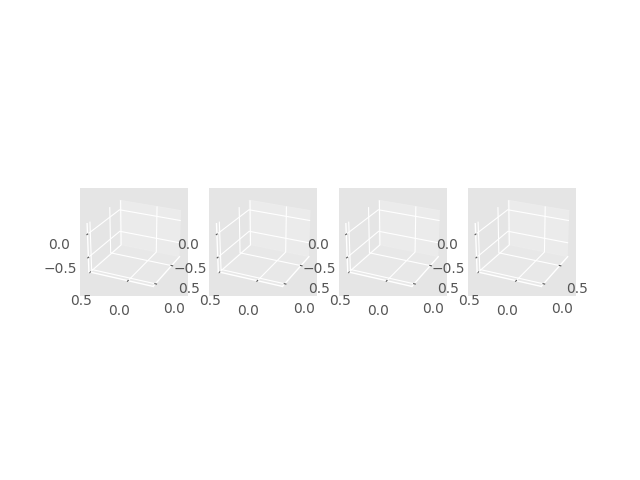

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
from utils import *
import asyncio

fig = plt.figure()
axs = []
i = 1
for z_dim in [3,5,8,10]:
    axs.append(fig.add_subplot(1,4,i, projection='3d'))
    i+=1
    axs[-1].view_init(25, -155)
    axs[-1].set_xlim3d([-0.05, 0.75])
    axs[-1].set_ylim3d([-0.3, 0.5])
    axs[-1].set_zlim3d([-0.8, 0.2])

async def update():
    global ax, preds, gt, test_dataset, recons
    for i in range(len(test_dataset.actidx)):
        for frame_idx in range(lens[0][i]):
            for j in range(4):
                axs[j] = reset_axis(axs[j])
                # axs[j] = visualize_skeleton(axs[j], gt[j][i][0][frame_idx].reshape((40,4,3)), markerfacecolor='r', linestyle='-', alpha=0.5)
                axs[j] = visualize_skeleton(axs[j], gt[j][i][1][frame_idx].reshape((40,4,3)), markerfacecolor='b', linestyle='-', alpha=0.5)
                # axs[j] = visualize_skeleton(axs[j], preds[j][i][0][frame_idx].reshape((40,4,3)), markerfacecolor='m', linestyle='-', alpha=0.5)
                axs[j] = visualize_skeleton(axs[j], preds[j][i][1][frame_idx].reshape((40,4,3)), markerfacecolor='c', linestyle='--', alpha=0.5)
                # axs[j] = visualize_skeleton(axs[j], preds[j][i][0][frame_idx].reshape((40,4,3)), markerfacecolor='m', linestyle='-', alpha=0.5)
                axs[j] = visualize_skeleton(axs[j], recons[j][i][1][frame_idx].reshape((40,4,3)), markerfacecolor='m', linestyle='-', alpha=0.5)
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            await asyncio.sleep(0.001)
loop = asyncio.get_event_loop()
loop.create_task(update());
